In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

In [3]:
print("Shape of training data:")
print(train_x.shape)
print(train_y.shape)
print("Shape of test data:")
print(test_x.shape)
print(test_y.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


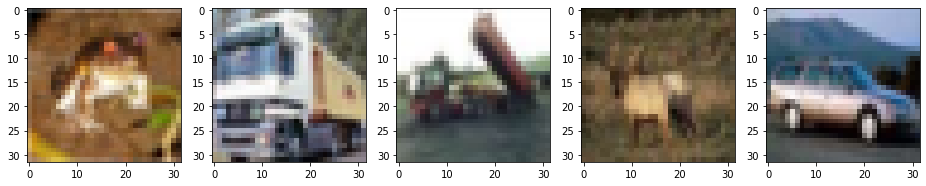

In [4]:
import matplotlib.pyplot as plt

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in train_y[0:5]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in train_y[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = train_x[i]
    axarr[i].imshow(img)
plt.show()

In [5]:
from keras.utils.np_utils import to_categorical  

input_shape = train_x.shape[1:]

train_x = train_x.astype(np.float32) / 255.
test_x = train_x.astype(np.float32) / 255.
train_y = to_categorical(train_y, num_classes=10)
test_y = to_categorical(test_y, num_classes=10)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

Using TensorFlow backend.


(50000, 32, 32, 3) float32
(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 10) float32


## Создание пайплайна данных

In [6]:
NUM_EPOCHS = 1
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Создание модели CNN

In [7]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3))
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(0.25)
        
    def call(self, inp):

        out = self.conv1(inp)      
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.dropout(out)
        out = self.conv3(out)      
        out = self.conv4(out)
        out = self.max_pool(out)
        out = self.dropout(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

## Функция потерь и функция вычисления точности

In [8]:
def loss(logits, labels):
#     labels = tf.cast(labels, tf.int64)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    logits = tf.cast(logits, tf.int64)
#     predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(logits, labels), dtype=tf.float32))

## Подготовка к обучению

In [10]:
LEARNING_RATE = 0.001

# optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# writer = tf.summary.create_file_writer('logs/sgd')
writer = tf.summary.create_file_writer('logs/adam')

## Цикл обучения модели

In [11]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if iteration % 200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, :])
        
        print("[%4d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)

[   0] Accuracy: 90.00 %
[ 200] Accuracy: 81.33 %
[ 400] Accuracy: 47.19 %
[ 600] Accuracy: 47.19 %
Wall time: 3min 59s


## Оценка качества модели

In [20]:
test_logits = model(test_x[:512, ...])
accuracy_value = accuracy(test_logits, test_y[:512, :]).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 47.58 %


## Реализация через стандартные функции

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [15]:
x_train = x_train.astype('float32')/ 255.
x_test = x_test.astype('float32')/ 255.

In [16]:
model2 = Model()
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
%%time
model2.fit(x_train, y_train,
          batch_size=128,
          epochs=1,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 176s 4ms/sample - loss: 8.0785 - accuracy: 0.1001 - val_loss: 8.0590 - val_accuracy: 0.1000
Wall time: 2min 56s


In [18]:
# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 10s 1ms/sample - loss: 8.0590 - accuracy: 0.1000
Test loss: 8.059047776794433
Test accuracy: 0.1
